[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema 

## Review

In module 1, we laid the foundations! We built up to an agent that can: 

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions
 
And, we showed how to serve it locally in LangGraph Studio or deploy it with LangGraph Cloud. 

## Goals

In this module, we're going to build a deeper understanding of both state and memory.

First, let's review a few different ways to define your state schema.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

It allows you to specify keys and their corresponding value types.
 
But, note that these are type hints. 

They can be used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run. 

But they are not enforced at runtime!

In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, you can use things like the `Literal` type hint.

Here, `mood` can only be either "happy" or "sad".

In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

And, we can think about each state key as just a "channel" in our graph. 

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
import mermaid as mm

Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the `name` key in our state.

In [5]:
graph.invoke({"name":"Lance"})

NameError: name 'graph' is not defined

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [6]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

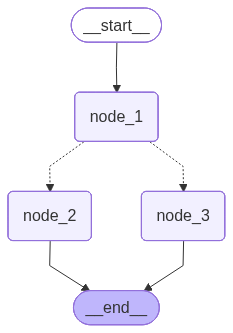

In [11]:
def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # For DataclassState, use attribute access
    user_input = state.name
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state.name + " I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state.mood + " happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state.mood + " sad!"}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We invoke with a `dataclass` to set the initial values of each key / channel in our state!

In [12]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance', 'mood': 'sad'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [13]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations. 

It's particularly well-suited [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/) due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [14]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


We can use `PydanticState` in our graph seamlessly. 

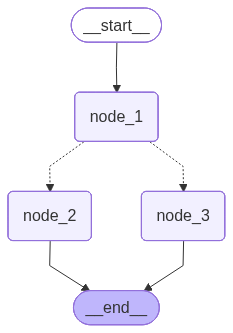

In [15]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance', 'mood': 'sad'}